<p style="text-align: center; font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;">
LoRaWAN Indoor Path Loss Measurements: RSSI Kalman Filtering for Localization use cases
</p>

# Overview

This notebook presents an end-to-end framework for enhancing wireless localization through advanced signal processing and propagation modeling. We tackle the inherent noise in Received Signal Strength Indicator (RSSI) measurements by applying a one-dimensional [Kalman filter](https://ani.stat.fsu.edu/~jfrade/HOMEWORKS/STA5107/presentation/sta5107-present/Kalman%20Filter/papers/kalman.pdf) — a recursive Bayesian estimator introduced by Kalman (1960).

In [1]:
  # Standard Library Imports

  # Data Manipulation
import pandas as pd                # Data structures & analysis
import numpy as np                 # Numerical computations

  # Data Visualization
import matplotlib.pyplot as plt    # Plotting library
import seaborn as sns              # Statistical data visualization
import matplotlib.ticker as ticker # Custom tick formatting
import matplotlib.dates as mdates  # Date formatting for plots
import matplotlib.patches as mpatches  # Shape and legend patches

  # Signal Processing
from pykalman import KalmanFilter                     # Kalman filtering

# Global Seaborn style (dark grid)
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=0.9)

In [2]:
# Load data and convert time column
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
#df = pd.read_csv('../LoRaWAN Localization - Advanced Files/all3_gateways_cleaned_dataset_per_device.csv')
df['time'] = pd.to_datetime(df['time'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079534 entries, 0 to 2079533
Data columns (total 20 columns):
 #   Column       Dtype              
---  ------       -----              
 0   time         datetime64[ns, UTC]
 1   device_id    object             
 2   co2          float64            
 3   humidity     float64            
 4   pm25         float64            
 5   pressure     float64            
 6   temperature  float64            
 7   rssi         float64            
 8   snr          float64            
 9   SF           int64              
 10  frequency    float64            
 11  f_count      float64            
 12  p_count      float64            
 13  toa          float64            
 14  distance     int64              
 15  c_walls      int64              
 16  w_walls      int64              
 17  exp_pl       float64            
 18  n_power      float64            
 19  esp          float64            
dtypes: datetime64[ns, UTC](1), float64(14), int64(

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-10-01 00:01:07.420593+00:00,ED5,440.0,45.46,0.46,313.80,22.41,-102.0,10.2,9,868.1,9868.0,10756.0,0.246784,40,2,2,119.26,-112.596121,-102.396121
1,2024-10-01 00:01:25.764905+00:00,ED2,451.0,40.59,0.43,314.81,22.83,-66.0,11.0,10,867.9,5815.0,6642.0,0.452608,23,0,2,83.26,-77.331956,-66.331956
2,2024-10-01 00:01:50.313519+00:00,ED4,435.0,37.33,0.05,315.54,24.06,-119.0,-1.8,10,867.1,9335.0,10753.0,0.452608,37,0,5,136.26,-121.202895,-123.002895
3,2024-10-01 00:02:07.467816+00:00,ED5,449.0,45.43,0.40,313.84,22.41,-100.0,10.8,9,867.7,9869.0,10757.0,0.246784,40,2,2,117.26,-111.146992,-100.346992
4,2024-10-01 00:02:25.817808+00:00,ED2,451.0,40.57,0.21,314.80,22.84,-64.0,8.8,10,867.7,5816.0,6643.0,0.452608,23,0,2,81.26,-73.337795,-64.537795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079529,2025-09-30 23:59:20.436955+00:00,ED1,765.0,43.17,1.32,332.23,22.95,-49.0,11.8,8,867.1,127208.0,127506.0,0.133632,8,1,0,66.26,-61.077855,-49.277855
2079530,2025-09-30 23:59:33.711547+00:00,ED4,626.0,37.18,0.28,333.20,24.63,-90.0,12.8,9,867.1,126741.0,127512.0,0.246784,37,0,5,107.26,-103.022142,-90.222142
2079531,2025-09-30 23:59:51.442628+00:00,ED3,725.0,48.96,1.91,331.95,20.43,-60.0,12.2,8,867.9,117189.0,117586.0,0.133632,18,1,2,77.26,-72.454107,-60.254107
2079532,2025-09-30 23:59:54.616737+00:00,ED5,493.0,46.30,3.16,331.90,22.49,-94.0,10.8,9,868.3,127147.0,127514.0,0.246784,40,2,2,111.26,-105.146992,-94.346992


###  Kalman Filtering

Kalman filtering provides an optimal estimation framework for linear systems corrupted by Gaussian noise.
The filter recursively computes the predicted state and its uncertainty, then updates these estimates with new observations through:

$$
K_k = \frac{P_{k|k-1}}{P_{k|k-1} + R}, \quad \hat{x}_k = \hat{x}_{k|k-1} + K_k (z_k - \hat{x}_{k|k-1})
$$

where $K_k$ is the Kalman gain and $P_{k|k-1}$ is the predicted covariance. This methodology mitigates transient measurement anomalies and refines the quality of the RSSI input for subsequent modeling tasks.


# SINGLE GATEWAY

In [3]:
# ------------------ Self‑tuning 1D Kalman filter for RSSI ------------------
def adaptive_kf_rssi(z,
                     Q_init=0.003,
                     R_init=0.22,
                     gamma_min=0.95,
                     gamma_max=1.05,
                     forget_factor=0.99,
                     R_guard=(0.12,0.38),
                     adapt_Q=False,
                     Q_bounds=(1e-5,2e-2)):
    n = len(z)
    x_hat = np.zeros(n)
    P_hat = np.zeros(n)
    x_hat[0] = z[0]
    P_hat[0] = R_init
    Q, R = Q_init, R_init
    for k in range(1, n):
        x_pred = x_hat[k-1]
        P_pred = P_hat[k-1] + Q
        innov  = z[k] - x_pred
        S      = P_pred + R
        K_gain = P_pred / S
        x_hat[k] = x_pred + K_gain * innov
        P_hat[k] = (1 - K_gain) * P_pred
        alpha = np.clip(innov**2 / S, gamma_min, gamma_max)
        R_new = forget_factor * R + (1 - forget_factor) * (alpha * R)
        R = np.clip(R_new, R_guard[0], R_guard[1])
        if adapt_Q:
            Q_new = forget_factor * Q + (1 - forget_factor) * (alpha * Q)
            Q = float(np.clip(Q_new, Q_bounds[0], Q_bounds[1]))
    return x_hat

def apply_self_tuning(df):
    return df.groupby('device_id')['rssi'].transform(
        lambda arr: adaptive_kf_rssi(arr.values,
                                     Q_init=0.003, R_init=0.22,
                                     gamma_min=0.95, gamma_max=1.05,
                                     forget_factor=0.99,
                                     R_guard=(0.12, 0.38),
                                     adapt_Q=False))

# ---- PyKalman baseline (random-walk 1D KF) ----
def run_pykalman(series, q=0.003, r=0.22):
    kf = KalmanFilter(
        transition_matrices=1.0,
        observation_matrices=1.0,
        transition_covariance=q,
        observation_covariance=r,
        initial_state_mean=series.iloc[0],
        initial_state_covariance=r,
    )
    means, _ = kf.filter(series.values)
    return pd.Series(means[:, 0], index=series.index)

# Apply both filters (sorted by time per device)
df = df.sort_values(['device_id', 'time'])
df['filtered_rssi'] = apply_self_tuning(df)
df['kf_rssi'] = (
    df.groupby('device_id', group_keys=False)['rssi']
      .apply(lambda s: run_pykalman(s, q=0.003, r=0.22))
)

# Path-loss using the same constants
offset = 17.26  # TX_P - TX_CL + TX_AG + RX_AG
df['exp_pl_filtered'] = offset - df['filtered_rssi']
df['exp_pl_kf'] = offset - df['kf_rssi']

### Kalman Filter Results

In [4]:
# Per-device std dev and reduction (raw vs adaptive vs PyKalman)
raw_std       = df.groupby('device_id')['rssi'].std()
adaptive_std  = df.groupby('device_id')['filtered_rssi'].std()
pykalman_std  = df.groupby('device_id')['kf_rssi'].std()

results_df = pd.DataFrame({
    'Raw_Std (dB)': raw_std,
    'Adaptive_Std (dB)': adaptive_std,
    'PyKalman_Std (dB)': pykalman_std,
})

results_df['Adaptive_Reduction (%)'] = (raw_std - adaptive_std) / raw_std * 100
results_df['PyKalman_Reduction (%)'] = (raw_std - pykalman_std) / raw_std * 100

print("\nReduction in RSSI standard deviation per device:\n")
display(results_df)

print("\nSummary:")
print("Average Raw RSSI Std Dev: {:.2f} dB".format(results_df['Raw_Std (dB)'].mean()))
print("Average Adaptive RSSI Std Dev: {:.2f} dB".format(results_df['Adaptive_Std (dB)'].mean()))
print("Average PyKalman RSSI Std Dev: {:.2f} dB".format(results_df['PyKalman_Std (dB)'].mean()))
print("Adaptive Avg Reduction: {:.2f}%".format(results_df['Adaptive_Reduction (%)'].mean()))
print("PyKalman Avg Reduction: {:.2f}%".format(results_df['PyKalman_Reduction (%)'].mean()))


Reduction in RSSI standard deviation per device:



,Raw_Std (dB),Adaptive_Std (dB),PyKalman_Std (dB),Adaptive_Reduction (%),PyKalman_Reduction (%)
device_id,,,,,
ED0,14.021343,6.392214,6.590080,54.410831,52.999650
ED1,14.249021,6.998515,7.175260,50.884240,49.643837
ED2,9.294914,5.501000,5.589350,40.817095,39.866576
ED3,12.639828,5.700970,5.885179,54.896772,53.439407
ED4,6.724083,3.704825,3.783119,44.902154,43.737773
ED5,5.028891,4.388824,4.415677,12.727793,12.193824



Summary:
Average Raw RSSI Std Dev: 10.33 dB
Average Adaptive RSSI Std Dev: 5.45 dB
Average PyKalman RSSI Std Dev: 5.57 dB
Adaptive Avg Reduction: 43.11%
PyKalman Avg Reduction: 41.98%


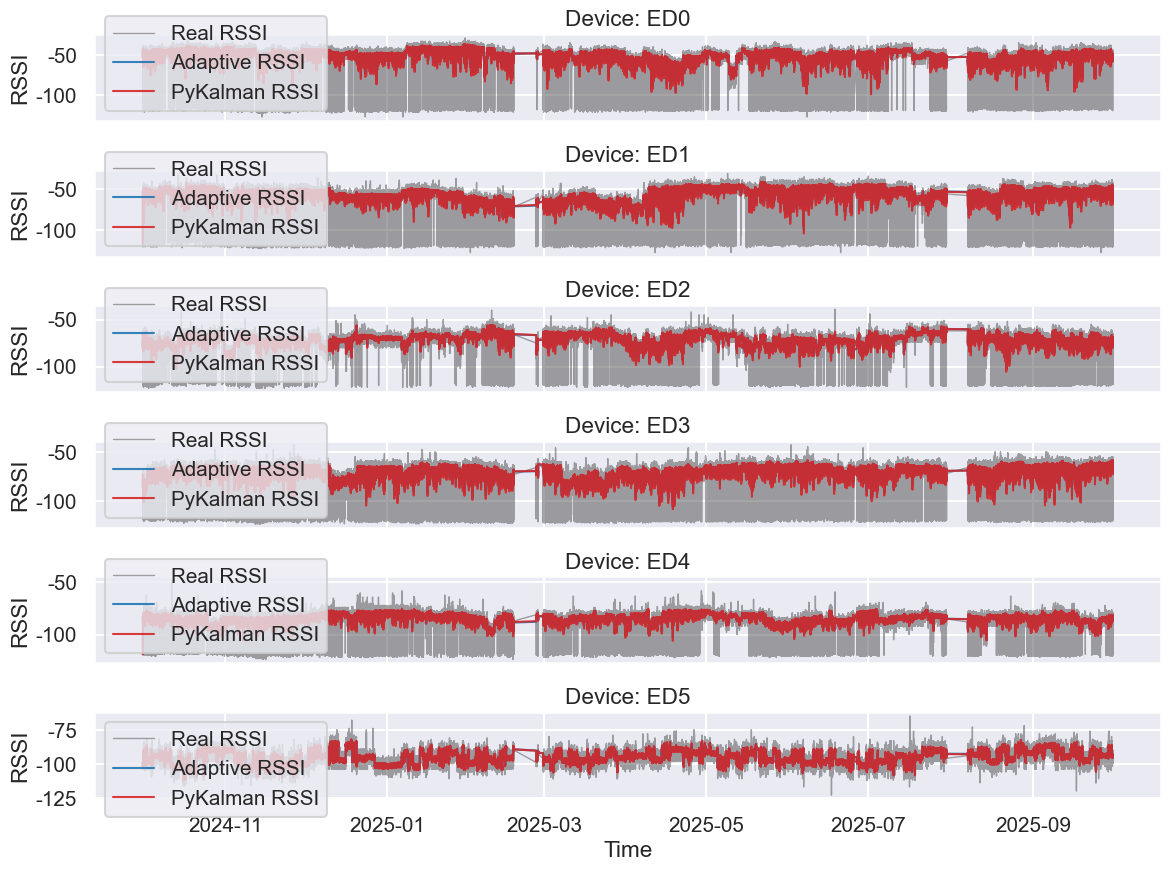

In [5]:
# Plot data (Real vs Adaptive vs PyKalman RSSI) for each device
colors = {'raw': '0.3', 'adaptive': '#1f77b4', 'pykalman': '#d62728'}
device_ids = df['device_id'].unique()
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 1.5*num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids):
    device_data = df[df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'],
            label='Real RSSI', color=colors['raw'], alpha=0.5, linewidth=1.0)
    ax.plot(device_data['time'], device_data['filtered_rssi'],
            label='Adaptive RSSI', color=colors['adaptive'], alpha=0.9, linewidth=1.5)
    ax.plot(device_data['time'], device_data['kf_rssi'],
            label='PyKalman RSSI', color=colors['pykalman'], alpha=0.9, linewidth=1.5)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

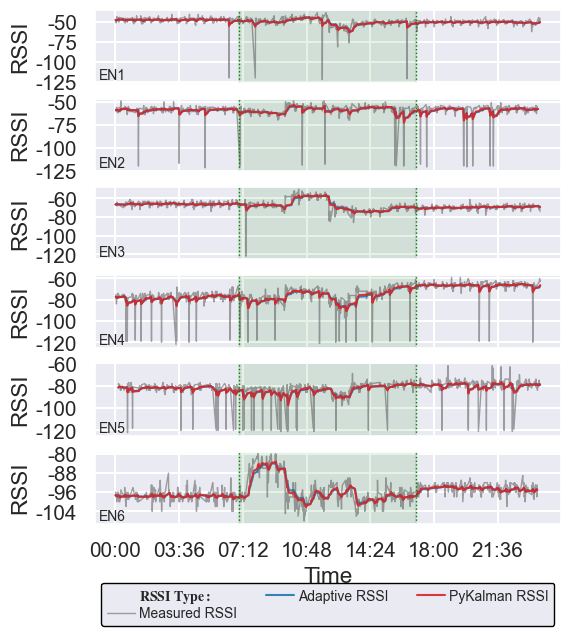

In [6]:
# Ensure 'time' column is datetime
df['time'] = pd.to_datetime(df['time'])

segment_start = '2024-12-20 00:00:00'
segment_end   = '2024-12-20 23:59:59'
df_segment = df[(df['time'] >= segment_start) & (df['time'] <= segment_end)]

device_map = {'ED0': 'EN1', 'ED1': 'EN2', 'ED2': 'EN3', 'ED3': 'EN4', 'ED4': 'EN5', 'ED5': 'EN6'}
device_ids = sorted(df_segment['device_id'].unique())
num_devices = len(device_ids)
colors = {'raw': '0.3', 'adaptive': '#1f77b4', 'pykalman': '#d62728'}

fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(6, 1 * num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

highlight_start = pd.to_datetime('2024-12-20 07:00:00')
highlight_end   = pd.to_datetime('2024-12-20 17:00:00')

for ax, device in zip(axes, device_ids):
    device_data = df_segment[df_segment['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'],
            label='Measured RSSI', color=colors['raw'], alpha=0.5, linewidth=1.0)
    ax.plot(device_data['time'], device_data['filtered_rssi'],
            label='Adaptive RSSI', color=colors['adaptive'], alpha=0.9, linewidth=1.5)
    ax.plot(device_data['time'], device_data['kf_rssi'],
            label='PyKalman RSSI', color=colors['pykalman'], alpha=0.9, linewidth=1.5)

    ax.axvspan(highlight_start, highlight_end, color='green', alpha=0.1)
    ax.axvline(highlight_start, color='green', linestyle=':', linewidth=1)
    ax.axvline(highlight_end,   color='green', linestyle=':', linewidth=1)

    device_label = device_map.get(device, device)
    ax.text(0.01, 0.01, device_label, transform=ax.transAxes,
            fontsize=10, va='bottom', ha='left')
    ax.set_ylabel('RSSI')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    for spine in ax.spines.values():
        spine.set_linewidth(2)

plt.tight_layout(h_pad=0.01)
fig.canvas.draw()

pos = axes[0].get_position()
handles, labels = axes[0].get_legend_handles_labels()
dummy_handle = mpatches.Patch(color='none', label=r'$\mathbf{RSSI\ Type:}$')
handles = [dummy_handle] + handles
labels = [r'$\mathbf{RSSI\ Type:}$'] + labels
legend = fig.legend(handles, labels,
                    loc='lower left',
                    bbox_to_anchor=(pos.x0, -0.08, pos.width, 0.05),
                    mode='expand', ncol=3, frameon=True,
                    fontsize=10, labelspacing=0.1,
                    columnspacing=0.5, handletextpad=0.3)
legend.get_frame().set_linewidth(1)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1)

plt.xlabel('Time')
plt.show()

# MULTI GATEWAY 

In [7]:
# Load data and convert time column
#df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df_2 = pd.read_csv('../LoRaWAN Localization - Advanced Files/all3_gateways_cleaned_dataset_per_device.csv')
df_2['time'] = pd.to_datetime(df_2['time'])
df_2.info()
df_2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411800 entries, 0 to 3411799
Data columns (total 21 columns):
 #   Column        Dtype              
---  ------        -----              
 0   time          datetime64[ns, UTC]
 1   gateway       object             
 2   device_id     object             
 3   co2           float64            
 4   humidity      float64            
 5   pm25          float64            
 6   pressure      float64            
 7   temperature   float64            
 8   rssi          float64            
 9   snr           float64            
 10  SF            int64              
 11  frequency     float64            
 12  f_count       float64            
 13  p_count       float64            
 14  toa           float64            
 15  distance_gw0  float64            
 16  c_walls_gw0   float64            
 17  w_walls_gw0   float64            
 18  exp_pl_gw0    float64            
 19  n_power       float64            
 20  esp           float64   

,time,gateway,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,...,frequency,f_count,p_count,toa,distance_gw0,c_walls_gw0,w_walls_gw0,exp_pl_gw0,n_power,esp
0,2024-10-01 00:01:07.420593+00:00,GW0,ED5,440.0,45.46,0.46,313.80,22.41,-102.0,10.2,...,868.1,9868.0,10756.0,0.246784,40.0,2.0,2.0,119.26,-112.596121,-102.396121
1,2024-10-01 00:01:25.764905+00:00,GW2,ED2,451.0,40.59,0.43,314.81,22.83,-66.0,11.0,...,867.9,5815.0,6642.0,0.452608,NaN,NaN,NaN,NaN,-77.331956,-66.331956
2,2024-10-01 00:01:25.764905+00:00,GW0,ED2,451.0,40.59,0.43,314.81,22.83,-66.0,11.0,...,867.9,5815.0,6642.0,0.452608,23.0,0.0,2.0,83.26,-77.331956,-66.331956
3,2024-10-01 00:01:50.313519+00:00,GW2,ED4,435.0,37.33,0.05,315.54,24.06,-119.0,-1.8,...,867.1,9335.0,10753.0,0.452608,NaN,NaN,NaN,NaN,-121.202895,-123.002895
4,2024-10-01 00:01:50.313519+00:00,GW0,ED4,435.0,37.33,0.05,315.54,24.06,-119.0,-1.8,...,867.1,9335.0,10753.0,0.452608,37.0,0.0,5.0,136.26,-121.202895,-123.002895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411795,2025-09-30 23:59:51.442628+00:00,GW0,ED3,725.0,48.96,1.91,331.95,20.43,-60.0,12.2,...,867.9,117189.0,117586.0,0.133632,18.0,1.0,2.0,77.26,-72.454107,-60.254107
3411796,2025-09-30 23:59:51.442628+00:00,GW2,ED3,725.0,48.96,1.91,331.95,20.43,-60.0,12.2,...,867.9,117189.0,117586.0,0.133632,NaN,NaN,NaN,NaN,-72.454107,-60.254107
3411797,2025-09-30 23:59:54.616737+00:00,GW0,ED5,493.0,46.30,3.16,331.90,22.49,-94.0,10.8,...,868.3,127147.0,127514.0,0.246784,40.0,2.0,2.0,111.26,-105.146992,-94.346992
3411798,2025-09-30 23:59:55.971870+00:00,GW0,ED2,780.0,38.50,1.19,332.47,25.46,-68.0,7.8,...,868.5,127238.0,127523.0,0.071936,23.0,0.0,2.0,85.26,-76.466832,-68.666832


In [8]:
# ------------------ Filters on all gateways ------------------
df_2['time'] = pd.to_datetime(df_2['time'])
df_2 = df_2.sort_values(['gateway', 'device_id', 'time'])

def adaptive_kf_rssi(z,
                     Q_init=0.003, R_init=0.22,
                     gamma_min=0.95, gamma_max=1.05,
                     forget_factor=0.99,
                     R_guard=(0.12,0.38),
                     adapt_Q=False, Q_bounds=(1e-5,2e-2)):
    n = len(z)
    x_hat = np.zeros(n); P_hat = np.zeros(n)
    x_hat[0] = z[0]; P_hat[0] = R_init
    Q, R = Q_init, R_init
    for k in range(1, n):
        x_pred = x_hat[k-1]; P_pred = P_hat[k-1] + Q
        innov = z[k] - x_pred; S = P_pred + R; K = P_pred / S
        x_hat[k] = x_pred + K * innov
        P_hat[k] = (1 - K) * P_pred
        alpha = np.clip(innov**2 / S, gamma_min, gamma_max)
        R = np.clip(forget_factor * R + (1 - forget_factor) * (alpha * R), R_guard[0], R_guard[1])
        if adapt_Q:
            Q = float(np.clip(forget_factor * Q + (1 - forget_factor) * (alpha * Q), Q_bounds[0], Q_bounds[1]))
    return x_hat

def apply_self_tuning(df):
    return df.groupby(['gateway','device_id'])['rssi'].transform(lambda arr: adaptive_kf_rssi(arr.values))

def run_pykalman(series, q=0.003, r=0.22):
    kf = KalmanFilter(
        transition_matrices=1.0,
        observation_matrices=1.0,
        transition_covariance=q,
        observation_covariance=r,
        initial_state_mean=series.iloc[0],
        initial_state_covariance=r,
    )
    means, _ = kf.filter(series.values)
    return pd.Series(means[:, 0], index=series.index)

df_2['filtered_rssi'] = apply_self_tuning(df_2)
df_2['kf_rssi'] = (
    df_2.groupby(['gateway','device_id'], group_keys=False)['rssi']
        .apply(lambda s: run_pykalman(s, q=0.003, r=0.22))
)

# Path-loss: only for GW0 (offset known), NaN otherwise
offset_gw0 = 17.26
df_2['exp_pl_filtered_gw0'] = np.where(df_2['gateway'] == 'GW0', offset_gw0 - df_2['filtered_rssi'], np.nan)
df_2['exp_pl_kf_gw0']       = np.where(df_2['gateway'] == 'GW0', offset_gw0 - df_2['kf_rssi'], np.nan)

In [9]:
stats = []
for (gw, dev), g in df_2.groupby(['gateway','device_id']):
    raw = g['rssi'].std()
    adapt = g['filtered_rssi'].std()
    pk = g['kf_rssi'].std()
    stats.append({
        'gateway': gw,
        'device_id': dev,
        'Raw_Std': raw,
        'Adaptive_Std': adapt,
        'PyKalman_Std': pk,
        'Adaptive_Reduction_%': (raw - adapt) / raw * 100 if raw else np.nan,
        'PyKalman_Reduction_%': (raw - pk) / raw * 100 if raw else np.nan,
    })

stats_df = pd.DataFrame(stats)
display(stats_df)

gw_summary = (
    stats_df.groupby('gateway')[['Adaptive_Reduction_%','PyKalman_Reduction_%']]
            .mean()
            .rename(columns={
                'Adaptive_Reduction_%': 'Adaptive_Avg_Reduction_%',
                'PyKalman_Reduction_%': 'PyKalman_Avg_Reduction_%'
            })
)
print("\nGateway-level mean reductions:")
display(gw_summary)

,gateway,device_id,Raw_Std,Adaptive_Std,PyKalman_Std,Adaptive_Reduction_%,PyKalman_Reduction_%
0,GW0,ED0,14.038051,6.184790,6.383737,55.942676,54.525477
1,GW0,ED1,14.275702,6.940640,7.115804,51.381448,50.154437
2,GW0,ED2,9.326378,5.418284,5.505817,41.903669,40.965115
3,GW0,ED3,12.709582,5.635508,5.820979,55.659377,54.200074
4,GW0,ED4,6.807585,3.672392,3.751841,46.054402,44.887343
5,GW0,ED5,5.003571,4.357045,4.383918,12.921282,12.384204
6,GW1,ED0,29.607123,9.783272,10.425955,66.956356,64.785654
7,GW1,ED1,23.962099,9.314139,9.761471,61.129704,59.262874
8,GW1,ED2,0.852803,0.179203,0.155079,78.986604,81.815328
9,GW1,ED3,18.842913,7.610515,7.945252,59.610732,57.834267



Gateway-level mean reductions:


,Adaptive_Avg_Reduction_%,PyKalman_Avg_Reduction_%
gateway,,
GW0,43.977142,42.852775
GW1,66.670849,65.924531
GW2,60.324048,59.008525


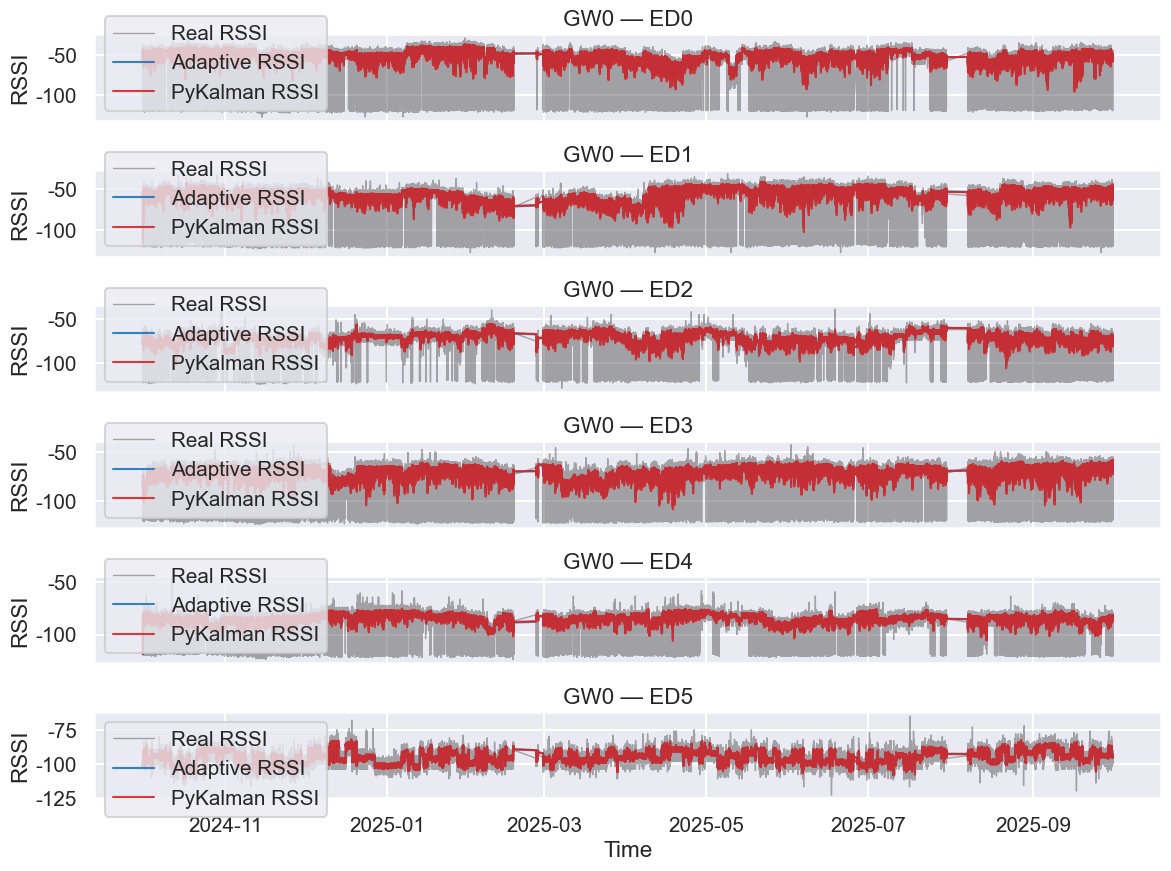

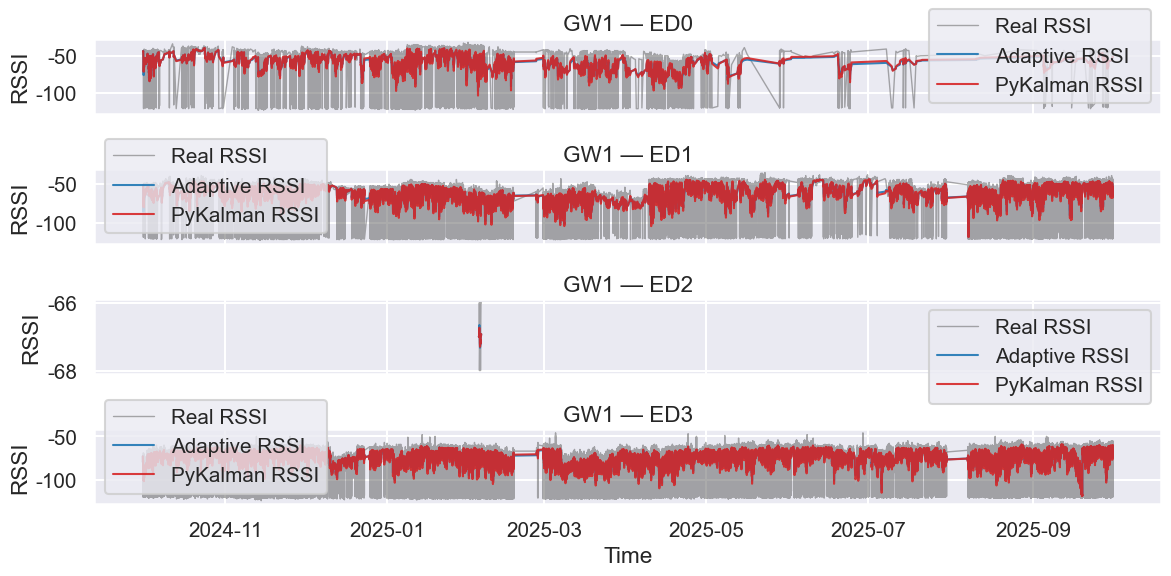

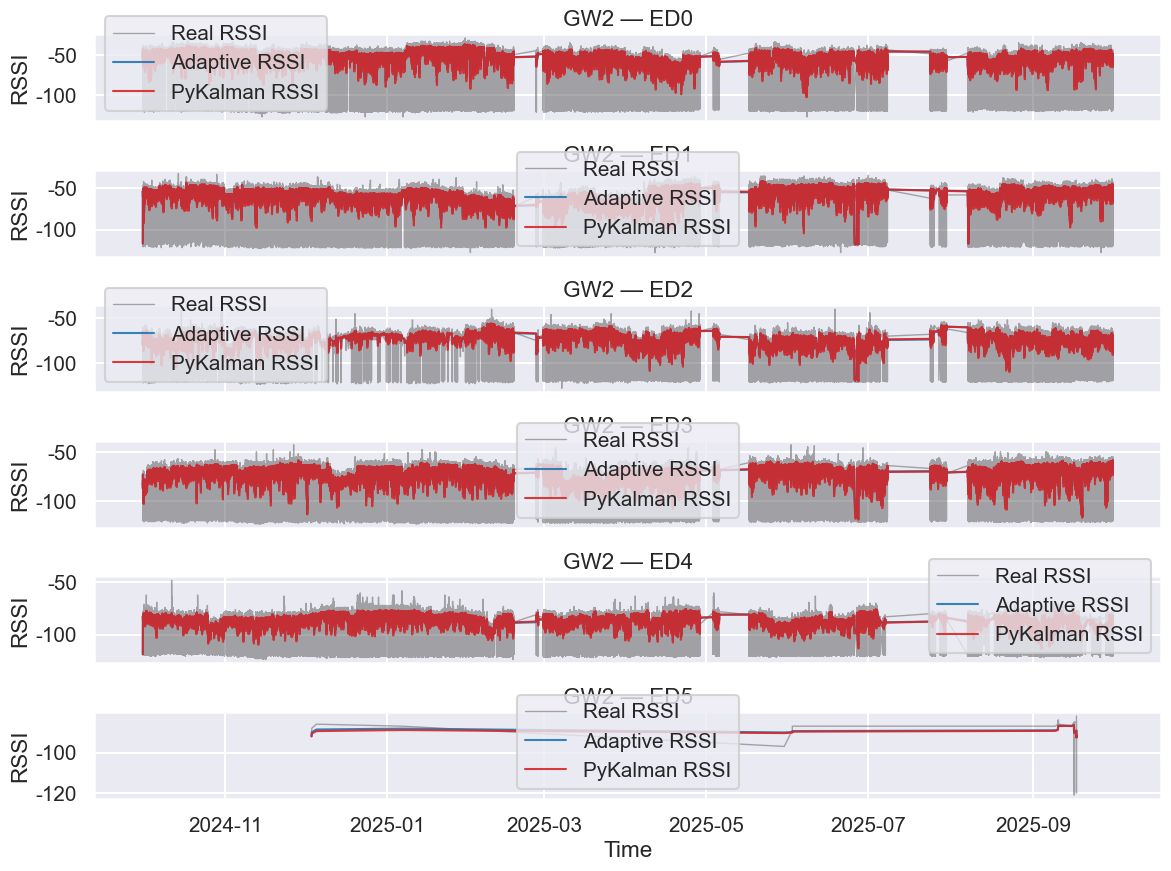

In [10]:
colors = {'raw': '0.35', 'adaptive': '#1f77b4', 'pykalman': '#d62728'}
for gw in df_2['gateway'].unique():
    gdf = df_2[df_2['gateway'] == gw]
    device_ids = gdf['device_id'].unique()
    num_devices = len(device_ids)
    fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 1.5*num_devices), sharex=True)
    if num_devices == 1:
        axes = [axes]
    for ax, dev in zip(axes, device_ids):
        d = gdf[gdf['device_id'] == dev].sort_values('time')
        ax.plot(d['time'], d['rssi'], label='Real RSSI', color=colors['raw'], alpha=0.5, linewidth=1.0)
        ax.plot(d['time'], d['filtered_rssi'], label='Adaptive RSSI', color=colors['adaptive'], alpha=0.9, linewidth=1.5)
        ax.plot(d['time'], d['kf_rssi'], label='PyKalman RSSI', color=colors['pykalman'], alpha=0.9, linewidth=1.5)
        ax.set_title(f'{gw} — {dev}')
        ax.set_ylabel('RSSI')
        ax.legend()
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

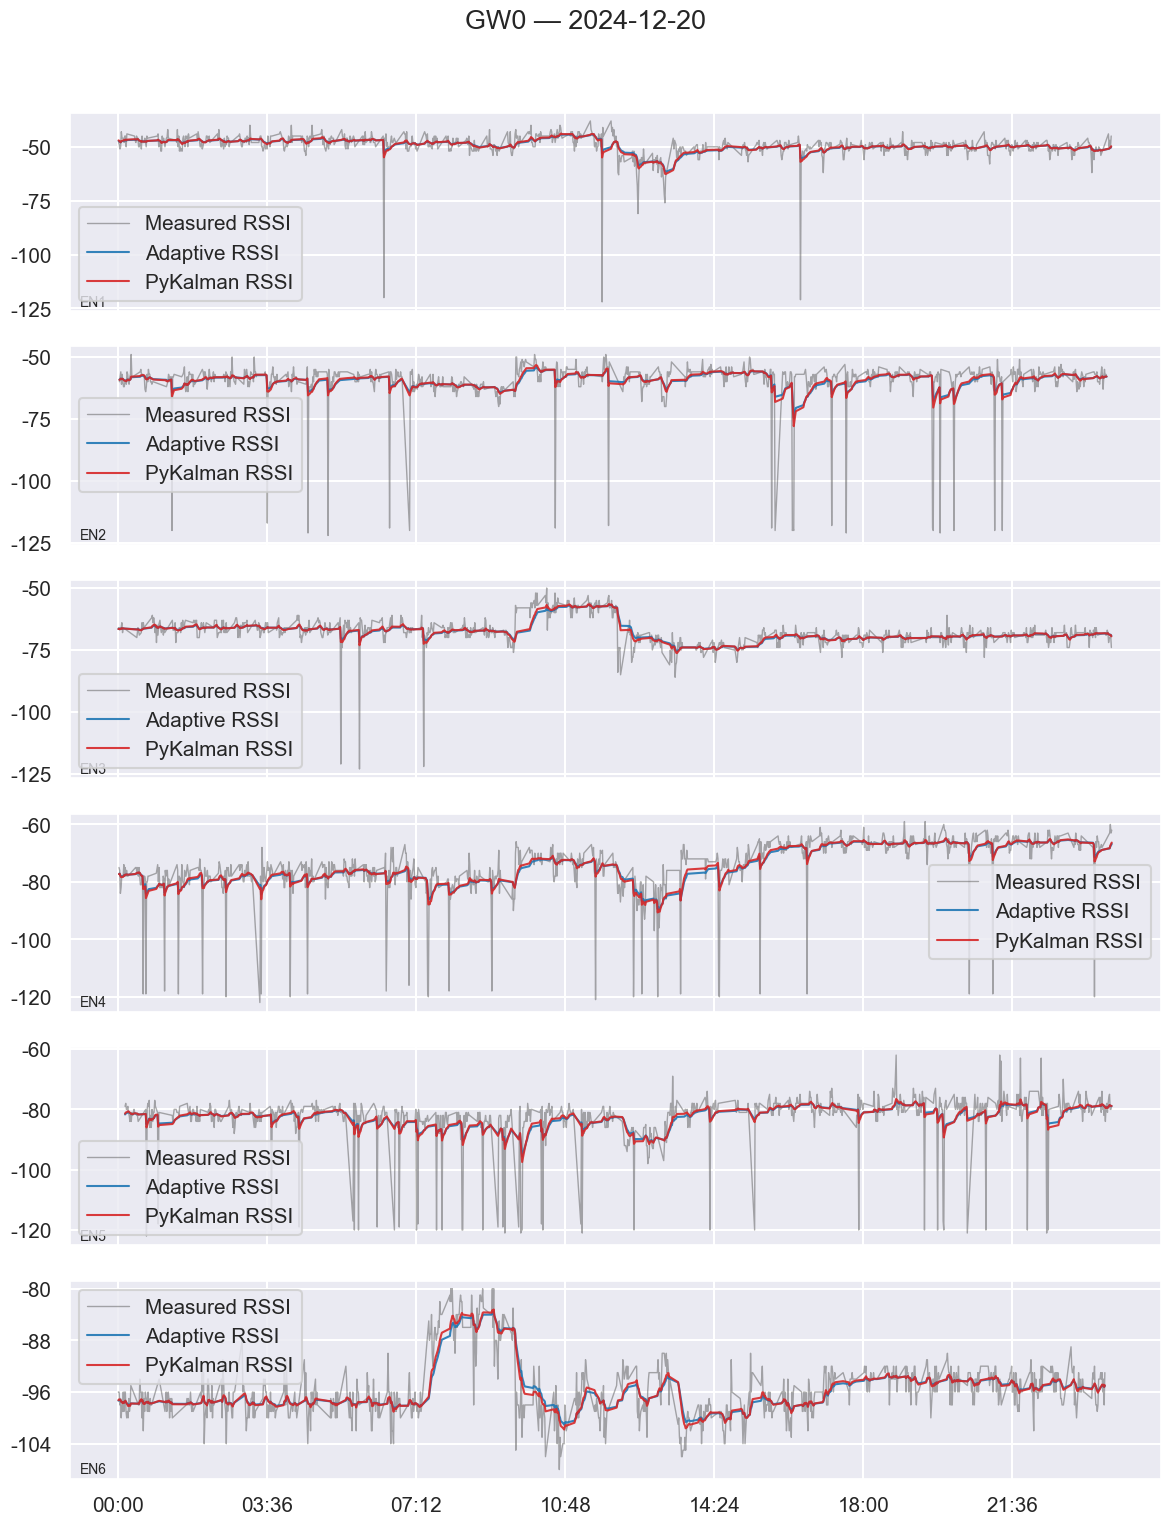

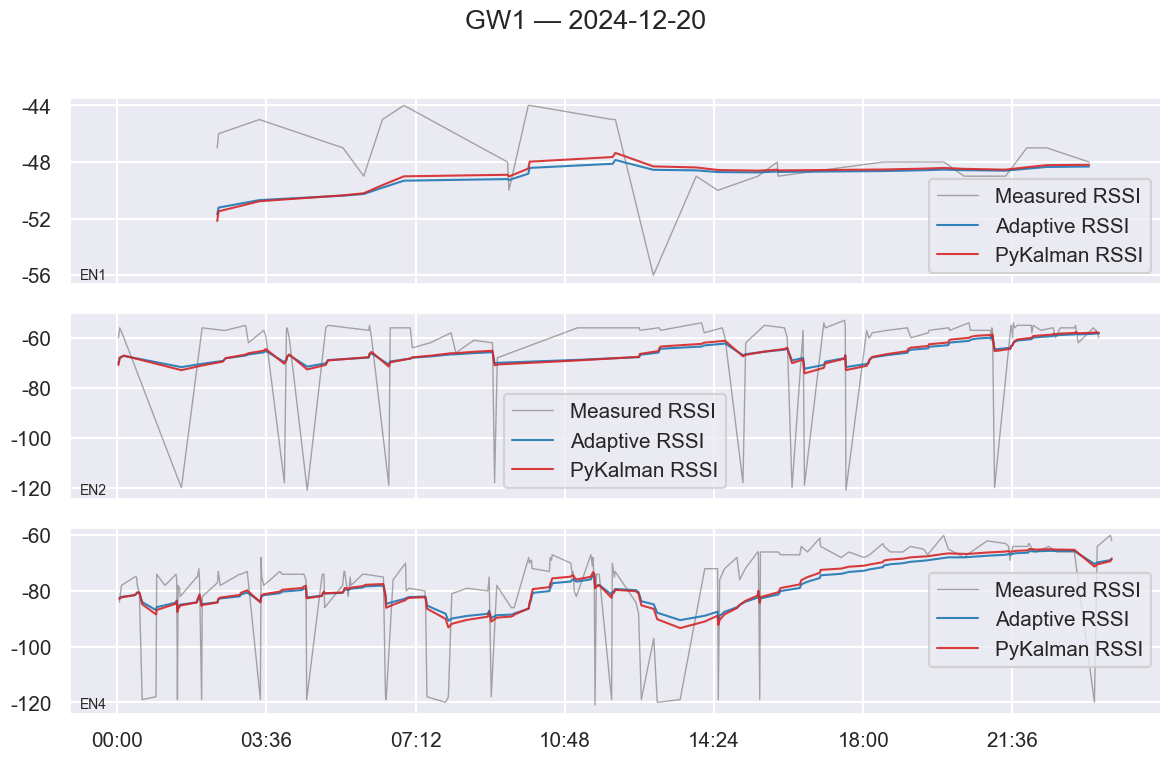

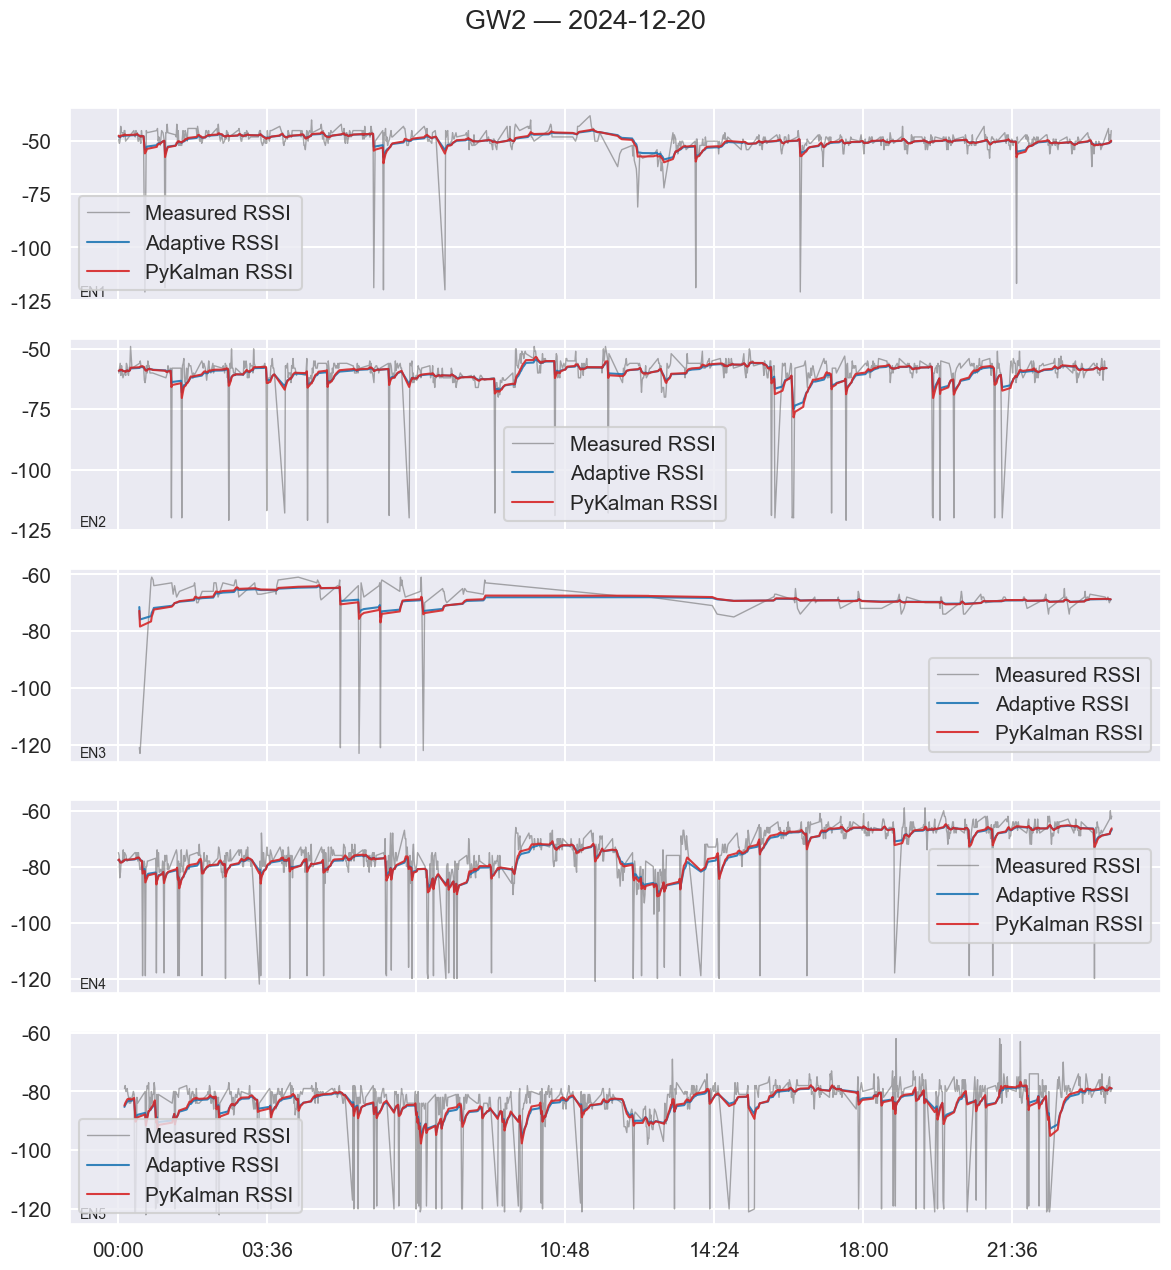

In [11]:
segment_start = '2024-12-20 00:00:00'
segment_end   = '2024-12-20 23:59:59'
df_seg = df_2[(df_2['time'] >= segment_start) & (df_2['time'] <= segment_end)]
colors = {'raw': '0.35', 'adaptive': '#1f77b4', 'pykalman': '#d62728'}
device_map = {'ED0': 'EN1', 'ED1': 'EN2', 'ED2': 'EN3', 'ED3': 'EN4', 'ED4': 'EN5', 'ED5': 'EN6'}  # adjust if needed

for gw in df_seg['gateway'].unique():
    gdf = df_seg[df_seg['gateway'] == gw]
    device_ids = sorted(gdf['device_id'].unique())
    num_devices = len(device_ids)
    fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 2.5 * num_devices), sharex=True)
    if num_devices == 1:
        axes = [axes]
    for ax, dev in zip(axes, device_ids):
        d = gdf[gdf['device_id'] == dev].sort_values('time')
        ax.plot(d['time'], d['rssi'], label='Measured RSSI', color=colors['raw'], alpha=0.5, linewidth=1.0)
        ax.plot(d['time'], d['filtered_rssi'], label='Adaptive RSSI', color=colors['adaptive'], alpha=0.9, linewidth=1.5)
        ax.plot(d['time'], d['kf_rssi'], label='PyKalman RSSI', color=colors['pykalman'], alpha=0.9, linewidth=1.5)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        label = device_map.get(dev, dev)
        ax.text(0.01, 0.01, label, transform=ax.transAxes, fontsize=10, va='bottom', ha='left')
        ax.legend()
    plt.suptitle(f'{gw} — 2024-12-20', y=1.02)
    plt.tight_layout()
    plt.show()

In [12]:
# Save Kalman-filtered datasets to CSV
gw0_output = '../LoRaWAN Localization - Advanced Files/gw0_kalman_filtered.csv'
all3_output = '../LoRaWAN Localization - Advanced Files/all3_gateways_kalman_filtered.csv'

df.to_csv(gw0_output, index=False)
df_2.to_csv(all3_output, index=False)

print(f'Kalman-filtered GW0 data saved to: {gw0_output}')
print(f'Kalman-filtered all-gateways data saved to: {all3_output}')

Kalman-filtered GW0 data saved to: ../LoRaWAN Localization - Advanced Files/gw0_kalman_filtered.csv
Kalman-filtered all-gateways data saved to: ../LoRaWAN Localization - Advanced Files/all3_gateways_kalman_filtered.csv
